In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/train_balanced_processed.csv')
df.columns

Index(['NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Accept',
       'BankStateInOhio', 'ApprovalDateMonth', 'ApprovalFYGrouped',
       'NoEmpGrouped', 'CreateJobBinary', 'RetainedJobBinary', 'IsFranchise',
       'DisbursementGrossGrouped'],
      dtype='object')

# Ingeniería de características

Debido a la importancia que toma `CreateJobBinary` en el modelo y la variabilidad de su afectación al eliminar `RetainedJobBinary`, se propone la creación de una nueva variable combinada con el objetivo de captar las posibles interacciones en entre ambas y valorar su efecto sobre el modelo. Para ello, obtenemos la matriz de correlación para ver si verdaderamente la distribución de la variable objetivo toma distintos valores en función de los posibles grupos

In [3]:
# Observamos la correlación de ambas variables y la proporción de los valores generados en función de accept
cross_tab = pd.crosstab(
    [df['CreateJobBinary'], df['RetainedJobBinary']],
    df['Accept'],
    normalize='index'  # Para ver proporciones por fila
)
cross_tab

Accept                                    0         1
CreateJobBinary RetainedJobBinary                    
0               0                  0.456512  0.543488
                1                  0.569731  0.430269
1               0                  0.303097  0.696903
                1                  0.541816  0.458184

In [4]:
# Creamos la nueva variable, eliminamos las anteriores y observamos la distribucción de la variable objetivo
df["JobCombo"] = df["CreateJobBinary"].astype(str) + "_" + df["RetainedJobBinary"].astype(str)
pd.crosstab(df["JobCombo"], df["Accept"], normalize='index')

Accept,0,1
JobCombo,,
0_0,0.456512,0.543488
0_1,0.569731,0.430269
1_0,0.303097,0.696903
1_1,0.541816,0.458184


### Conclusión
Se observan valores discriminativos en la nueva variable creada, por lo que se considera relevante probar su inclusión en el modelo. Para ello, se eliminan las dos variables anteriores y se introduce `JobCombo`como característica.

In [5]:
# Selección de las variables categóricas a evaluar
cat_features = [
    #'City', 
    #'CityBankGrouped',
    #'CityGrouped',
    #'BankState', 
    'BankStateInOhio',
    'UrbanRural',
    #'NoEmp', 
    #'NoEmpGrouped',
    #'CreateJob',
    #'CreateJobBinary',
    #'RetainedJob',
    #'RetainedJobBinary',
    #'NewExist', 
    #'RevLineCr',
    #'LowDoc',
    #'Accept',
    #'ApprovalDateMonth',
    'ApprovalFYGrouped',
    #'IsFranchise',
    'DisbursementGrossGrouped',
    'JobCombo'
]
#drop_columns = ["Accept"]
drop_columns = ["Accept","CreateJobBinary","RetainedJobBinary","IsFranchise","NoEmpGrouped","ApprovalDateMonth","LowDoc","NewExist","RevLineCr"]


In [6]:
X = df.copy().drop(columns=drop_columns)  # Características
y = df.copy()["Accept"]  # Variable objetivo (aceptación del crédito)

# División en conjunto de test y entrenamiento
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Dividimos train/validación aunque se considera que el dataset es pequeño - prueba
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Parametrización del modelo inicial

In [7]:
# ------------------------------------------
# Parámetros del modelo - Ajustados con GridSearchCV y Random
# ------------------------------------------

# Seleccion de variables categóricas

params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 8,
    'l2_leaf_reg': 6,
    #'loss_function': 'Logloss',
    'eval_metric': 'F1',
    #'auto_class_weights':'Balanced',
    'early_stopping_rounds':100,
    'random_state': 42,
    'verbose': 100
}

# Crear el modelo usando **params
model = CatBoostClassifier(**params)
#model.fit(X_train, y_train)
# Entrenar con eval_set

model.fit(
    X_train_split, y_train_split,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)


0:	learn: 0.6300223	test: 0.6269316	best: 0.6269316 (0)	total: 62.6ms	remaining: 31.3s
100:	learn: 0.7239669	test: 0.6637650	best: 0.6666667 (71)	total: 437ms	remaining: 1.73s
200:	learn: 0.7878955	test: 0.6687697	best: 0.6787234 (144)	total: 743ms	remaining: 1.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6787234043
bestIteration = 144

Shrink model to first 145 iterations.


## Evaluacion del modelo

In [8]:
# Evaluación
y_pred = model.predict(X_test)
print("F1_score:", f1_score(y_test, y_pred))
print("\nClasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))

F1_score: 0.6475548060708264

Clasificación:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       579
           1       0.65      0.65      0.65       592

    accuracy                           0.64      1171
   macro avg       0.64      0.64      0.64      1171
weighted avg       0.64      0.64      0.64      1171


Matriz de confusión:
 [[369 210]
 [208 384]]


Mejor F1: 0.3101 con umbral = 0.31


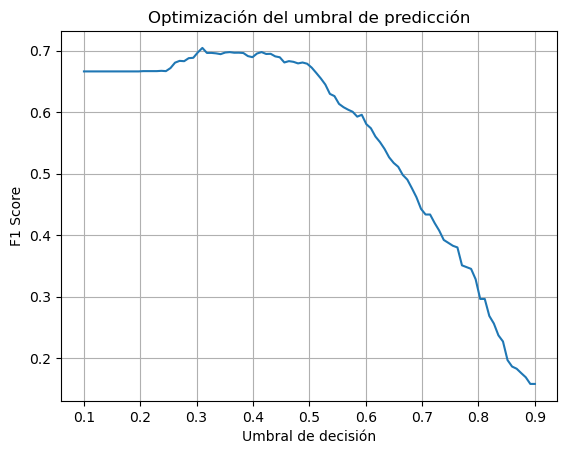

In [9]:
import numpy as np
from sklearn.metrics import f1_score

y_proba = model.predict_proba(X_val)[:, 1]  # Probabilidad de clase 1

f1_scores = []

# Probamos con umbrales de 0,1 a 0,9
thresholds = np.linspace(0.1, 0.9, 100)
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor F1: {best_threshold:.4f} con umbral = {best_threshold:.2f}")
# Para validación
y_val_final = (y_proba > best_threshold).astype(int)

# Graficamos el Resultado
plt.plot(thresholds, f1_scores)
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 Score")
plt.title("Optimización del umbral de predicción")
plt.grid(True)
plt.show()


AUC-ROC: 0.735


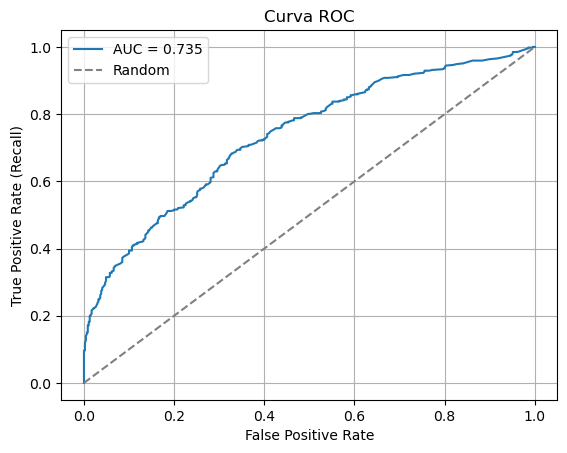

In [10]:
# Curva ROC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Probabilidades para la clase 1
y_probs = model.predict_proba(X_val)[:, 1]

# AUC Score
auc = roc_auc_score(y_val, y_probs)
print(f"AUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

[17.83064909 11.71688789 31.23622472 17.28835168 21.92788663]


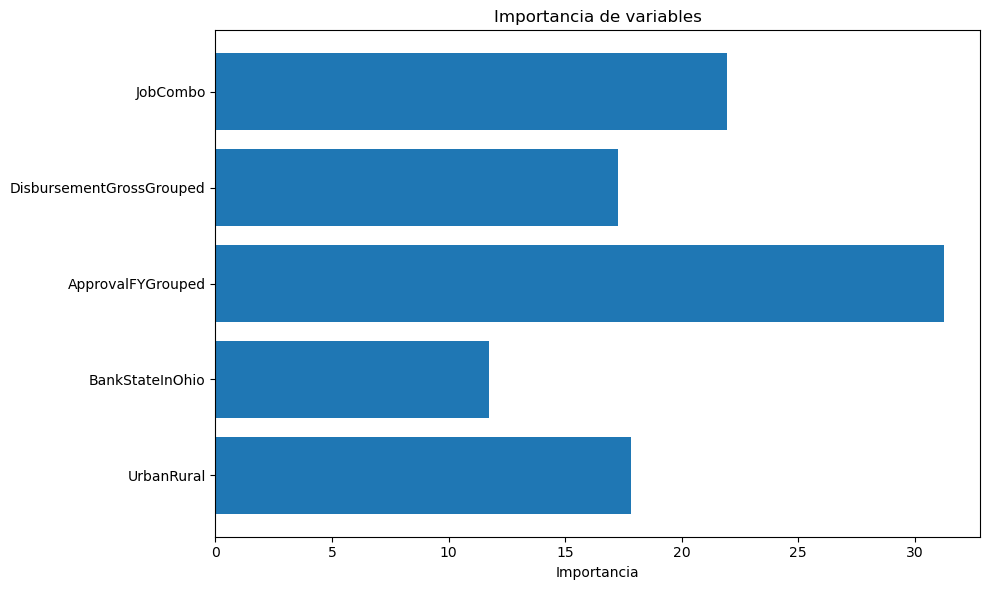

In [11]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance()
features = X_train.columns

print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title("Importancia de variables")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


### Conclusiones

- Se observa una importancia significativa de las variables `ApprovalFYGrouped` y `ApprovalaDateMonth`, mostrando una clara componente temporal en la asignación de los préstamos.
- La influencia de la localización se ve reflejada en `BankStateInOhio` u `UrbanRural`
- Podría evaluarse el rendimiento de un modelo centrado en un top de variables más importantes.

1. Se entrena un modelo centrado en las variables con más relevancia para evaluar los resultados. Concretamente, se eliminan las variables `LowDoc`, `RetainedJobBinary`,`IsFranchise` y `NoEmpGrouped`. **El f1_macro baja un 1%**
2. Se propone la creación de una variable imputada que combine la información obtenida en `RetainedJobBinary` Y `CreatedJobBinary` y se observa que su efecto es positivo. Se convierte en una variable que toma gran importancia. El rendimiento del modelo no sube pero se experimentan cambios significativos en la importancia de las variables por lo que se evalúa un nuevo modelo con el Top5.

## Búsqueda de Hiperparámetros

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'depth': [2, 4, 6],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
    'iterations': [100,200,300,400,500], 
}

model = CatBoostClassifier(
    verbose=100,
    random_state=42,
    eval_metric="F1"  # o GPU si tienes disponible
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

grid_search.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 135 candidates, totalling 675 fits
0:	learn: 0.6632100	test: 0.6724304	best: 0.6724304 (0)	total: 50.9ms	remaining: 5.04s
99:	learn: 0.6352677	test: 0.6593407	best: 0.6724304 (0)	total: 205ms	remaining: 0us

bestTest = 0.6724303554
bestIteration = 0

Shrink model to first 1 iterations.
[CV 3/5] END depth=2, iterations=100, l2_leaf_reg=3, learning_rate=0.03;, score=0.612 total time=   0.3s
0:	learn: 0.6657244	test: 0.6724304	best: 0.6724304 (0)	total: 1.2ms	remaining: 119ms
99:	learn: 0.6402422	test: 0.6608123	best: 0.6724304 (0)	total: 99.4ms	remaining: 0us

bestTest = 0.6724303554
bestIteration = 0

Shrink model to first 1 iterations.
[CV 1/5] END depth=2, iterations=100, l2_leaf_reg=3, learning_rate=0.05;, score=0.604 total time=   0.2s
0:	learn: 0.6660368	test: 0.6724304	best: 0.6724304 (0)	total: 889us	remaining: 88ms
99:	learn: 0.6491228	test: 0.6593407	best: 0.6724304 (0)	total: 289ms	remaining: 0us

bestTest = 0.6724303554
bestIteration = 0

Shrink mo

In [13]:
# Obtenemos el mejor estimador
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
# RandomizedSearchCV {'depth': 6, 'iterations': 434, 'l2_leaf_reg': 5, 'learning_rate': 0.0750499251969543}

Mejores hiperparámetros encontrados:
{'depth': 6, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.03}


Mejor F1: 0.4475 con umbral = 0.45


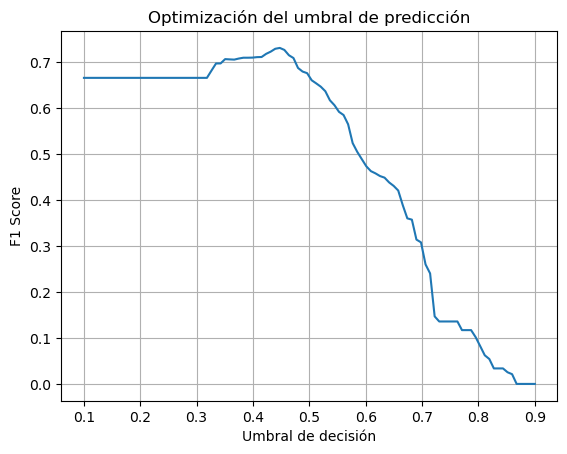

In [14]:
# Probabilidades y predicción
# y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

f1_scores = []
# Probamos con umbrales de 0,1 a 0,9
thresholds = np.linspace(0.1, 0.9, 100)
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor F1: {best_threshold:.4f} con umbral = {best_threshold:.2f}")
# Para validación
y_val_final = (y_proba > best_threshold).astype(int)

# Graficamos el Resultado
plt.plot(thresholds, f1_scores)
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 Score")
plt.title("Optimización del umbral de predicción")
plt.grid(True)
plt.show()

In [15]:
# Reporte de clasificación para umbral
print(classification_report(y_val, y_val_final))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68       470
           1       0.68      0.79      0.73       467

    accuracy                           0.71       937
   macro avg       0.71      0.71      0.71       937
weighted avg       0.71      0.71      0.71       937



### Conclusión

- El modelo básico comienza con una precisión del 63%. Sobre éste, se detecta el umbral de decisión óptimo, logrando una mejora de un 1%. Tras la búsqueda del mejor estimador, se realiza la primera submission y se detecta overfitting, por lo que se introducen parámetros como `l2_leaf_reg` y `early_stopping_round` para controlar el sobreajuste. Tambiñén se utiliza la división de los datos de entrenamiento en conjunto de train y validación, a pesar de que las dimensiones del dataset son más reducidas que el original. En estas iteraciones se observa que el overfitting se da por debajo de las 100/200 iteraciones del modelo, por lo que se empiezan a valorar rangos menores. 
- Tras observar la importancia de las variables evaluadas, se eliminan las variables de menor importancia para el aprendizaje del modelo, observándose una bajada del F1 Score del 1% sobre el valor previamente obtenido y una gran variabilidad en la importancia de las variables remanentes. Concretamente, las variables que en el primer caso tenían una importancia media/alta, pasan a quedar relegadas y el modelo comienza a tomar decisiones solo en base a dos variables: ApprovalFYGrouped y BankStateInOhio. Para suplir este hecho, se reevalúan los mejores hiperparámetros, llegando a un máximo de F1 Score de 65%.
- Debido a que la eliminación de variables no da resultado, se valora la posibilidad de tomar nuevas combinaciones de variables. Concretamente, se combina el efecto de las variables `CreateJobBinary`y `RetainedJobBinary`y se observa una mejora significativa en la distribución de importancia de variables del modelo. Tras el análisis, se observa una importancia significativa de cinco variables principales: `ApprovalFYGrouped`,`DisbursementGrossGrouped`,`JobCombo`,`BankStateInOhio`y `UrbanRural`.
- Se prueba el mejor estimador con las variables encontradas llegando a un porcentaje del 71%, que tras la subida en Kaggle queda en un 66%. Esto indica la presencia de sobreajuste en el estimador, por lo que se prueba con conjunto de validación.

In [16]:
from catboost import Pool

df_test_id = pd.read_csv("../../../data/processed/test_nolabel_processed.csv")

drop_columns.append("id")
drop_columns.remove("Accept")

# Se añaden y eliminan las columnas correspondientes para que ambos datasets tengan la misma estructura
df_test_id["JobCombo"] = df_test_id["CreateJobBinary"].astype(str) + "_" + df_test_id["RetainedJobBinary"].astype(str)
df_test = df_test_id.drop(columns=drop_columns) 

# Se crea el Pool de CatBoost con las mismas features que en el entrenamiento y se evalua el mejor modelo con el threshold
test_pool = Pool(df_test, cat_features=cat_features)
y_test_proba = best_model.predict_proba(test_pool)[:, 1]
df_test_id["Accept"] = (y_test_proba > best_threshold).astype(int)

# Crea el archivo CSV con las columnas requeridas: 'id' y 'Accept'
filename = f"CatBoost_BALANCED_{datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S')}.csv"
df_test_id.to_csv(filename, columns=['id', 'Accept'], index=False)

print("Archivo de submission ", filename, " generado correctamente.")

Archivo de submission  CatBoost_BALANCED_20250410_10_09_13.csv  generado correctamente.
